To install rascal:
(NOTE: See the top-level README for the most up-to-date installation instructions.)
+ mkdir ../build 
+ cd build
+ cmake -DCMAKE_BUILD_TYPE=Release -DBUILD_TESTS=ON ..
+ make -j 4
+ make install

In [1]:
%matplotlib notebook
from matplotlib import pylab as plt

import os, sys
from ase.io import read
sys.path.insert(0,"../build/")

import sys
import time
import rascal
import json

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
import sys
#import pandas
import scipy
import json

from rascal.representations import SOAP

In [2]:
import sklearn

In [2]:
#frames = read('./data/small_molecules-1000.xyz',':600')
frames = read('./data/CSD-500.xyz',':3')

In [3]:
n_atoms = sum(frame.get_number_of_atoms() for frame in frames)

In [4]:
chem_shifts = []
for frame in frames:
    chem_shifts.append(frame.arrays['CS'])

In [5]:
chem_shifts[1].shape

(62, 2)

In [6]:
chem_shifts_atoms = np.concatenate(chem_shifts, axis=0)

In [7]:
chem_shifts_atoms.shape

(362, 2)

# SOAP: Power spectrum

In [8]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [9]:
%time representation = soap.transform(frames)

CPU times: user 27.2 ms, sys: 7.14 ms, total: 34.3 ms
Wall time: 33.2 ms


In [10]:
X = representation.get_feature_matrix().T

In [11]:
X.shape

(362, 2520)

# Learning the chemical shifts of a set of crystal structures

## learning utilities

In [85]:
def compute_representation(representation, frames):
    result = representation.transform(frames)
    return result

#def compute_representation(frames):
#    expansions = soap.transform(frames)
#    return expansions

def compute_atomic_kernel(zeta, rep1, rep2=None):
    if rep2 is not None:
        kernel = rep1.cosine_kernel_atomic(rep2, zeta)
    else:
        kernel = rep1.cosine_kernel_atomic(zeta)
    return kernel

def extract_energy(frames):
    prop = [[]]*len(frames)
    for ii,cc in enumerate(frames):
        #prop[ii] = cc.info['dft_formation_energy_per_atom_in_eV']
        prop[ii] = cc.info['ENERGY']
    y = np.array(prop)
    return y

def split_dataset(frames, test_fraction, seed=10):
    N = len(frames)
    ids = np.arange(N)
    np.random.seed(seed)
    np.random.shuffle(ids)
    Ntrain = int(N*test_fraction)
    train = ids[:Ntrain]
    test = ids[Ntrain:]
    targets = extract_energy(frames)
    return [frames[ii] for ii in train],targets[train],[frames[ii] for ii in test],targets[test]

def get_mae(ypred,y):
    return np.mean(np.abs(ypred-y))
def get_rmse(ypred,y):
    return np.sqrt(np.mean((ypred-y)**2))
def get_sup(ypred,y):
    return np.amax(np.abs((ypred-y)))
def get_r2(y_pred,y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,dtype=np.float64)
    denominator = (weight * (y_true - np.average(
        y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)


score_func = dict(
    MAE=get_mae,
    RMSE=get_rmse,
    SUP=get_sup,
    R2=get_r2,
)

def get_score(ypred,y):
    scores = {}
    for k,func in score_func.items():
        scores[k] = func(ypred,y)
    return scores

class KRR(object):
    def __init__(self,zeta,weights,representation,X):
        self.weights = weights
        self.representation = representation
        self.zeta = zeta
        self.X = X
        
    def predict(self,frames):
        features = compute_representation(self.representation,frames)
        kernel = compute_atomic_kernel(self.zeta, self.X, features)
        return np.dot(self.weights, kernel)

def train_krr_model(zeta,Lambda,representation,frames,y,jitter=1e-8):
    features = compute_representation(representation, frames)
    kernel = compute_atomic_kernel(zeta, features, features)    
    # adjust the kernel so that it is properly scaled
    delta = np.std(y) / np.mean(kernel.diagonal())
    kernel[np.diag_indices_from(kernel)] += Lambda**2 / delta **2 + jitter
    # train the krr model
    weights = np.linalg.solve(kernel,y)
    model = KRR(zeta, weights,representation, features)
    return model,kernel


In [40]:
compute_representation(soap, frames)

## With the full power spectrum

In [15]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=1, 
              max_angular=1, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [72]:
frames_train, y_train, frames_test, y_test = split_dataset(frames,0.5)

In [77]:
y_train = np.concatenate([frame.arrays['CS'] for frame in frames_train], axis=0)

In [79]:
y_train = y_train[:,0]

In [80]:
y_test = np.concatenate([frame.arrays['CS'] for frame in frames_test], axis=0)

In [81]:
y_test = y_test[:,0]

In [21]:
n_atoms = sum(frame.get_number_of_atoms() for frame in frames_train)

In [23]:
zeta = 2

In [41]:
features = compute_representation(soap, frames_train)

In [42]:
features

In [43]:
kernel = compute_atomic_kernel(zeta, features, features)

In [44]:
kernel.shape

(192, 192)

In [ ]:
# WTF?
#for i in range(len(kernel)):
#    kernel[i][0] = np.sqrt(i)/50

In [45]:
kernel[191]

array([0.87975054, 0.87975011, 0.49779814, 0.49779687, 0.98109669,
       0.98109655, 0.97126864, 0.97126861, 0.91587672, 0.9158767 ,
       0.97851302, 0.97851297, 0.95344718, 0.95344855, 0.83970715,
       0.8397069 , 0.79162966, 0.79162941, 0.96773011, 0.96772993,
       0.82529327, 0.82529384, 0.8881505 , 0.88815069, 0.94375042,
       0.94375023, 0.92205162, 0.92205186, 0.86149486, 0.86149195,
       0.79534543, 0.79534568, 0.8378023 , 0.8378011 , 0.90498866,
       0.904989  , 0.60167486, 0.60167399, 0.89544877, 0.89544963,
       0.92167166, 0.92167086, 0.86299596, 0.8629965 , 0.89672925,
       0.89672931, 0.73019062, 0.73019261, 0.87671358, 0.87671315,
       0.46257458, 0.46257598, 0.9556616 , 0.9556621 , 0.9712882 ,
       0.97128821, 0.91437759, 0.91437758, 0.96499318, 0.96499324,
       0.97879083, 0.97879072, 0.94472353, 0.94472303, 0.78042708,
       0.78042764, 0.83473602, 0.83473592, 0.82510867, 0.82510945,
       0.85135696, 0.85135702, 0.90473988, 0.90473907, 0.84017

In [99]:
# First, try without regularization -- the results will be nonsense
weights = np.linalg.solve(kernel,y_train)

In [47]:
weights.shape

(192,)

In [64]:
model = KRR(zeta, weights, soap, features)

In [82]:
y_pred = model.predict(frames_test)
get_score(y_pred, y_test)

{'MAE': 699157.4569411766,
 'RMSE': 1375567.3621530985,
 'SUP': 6343226.83,
 'R2': -403832609.301558}

In [100]:
zeta = 2
Lambda = 10
krr,k = train_krr_model(zeta, Lambda, soap, frames_train, y_train)

In [101]:
y_pred = krr.predict(frames_test)
get_score(y_pred, y_test)

{'MAE': 87.45546029023231,
 'RMSE': 122.69989149493858,
 'SUP': 462.4729322590971,
 'R2': -2.213113137547772}

<IPython.core.display.Javascript object>


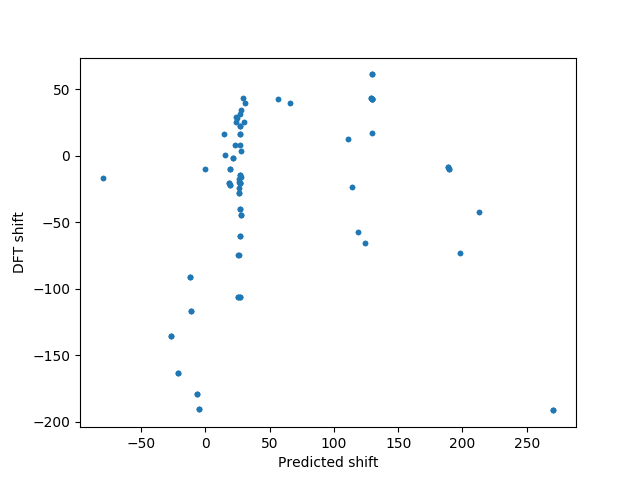

In [103]:
#sc = plt.scatter(y_pred, y_test, s=3)
#ax = plt.axis('scaled')
plt.plot(y_test, y_pred, '.')
plt.ylabel('DFT shift')
plt.xlabel('Predicted shift')
plt.savefig('R1.png', dpi=300)

## With just the radial spectrum

In [6]:
hypers = dict(soap_type="RadialSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=0, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5
              )
soap = SOAP(**hypers)

In [26]:
frames_train, y_train, frames_test, y_testr = split_dataset(frames,0.4)

In [27]:
zeta = 2
Lambda = 5e-3
krr,k = train_krr_model(zeta, Lambda, soap, frames_train, y_train)

In [28]:
y_predr = krr.predict(frames_test)
get_score(y_predr, y_testr)

{'MAE': 0.016904908533592014,
 'RMSE': 0.02323390852217482,
 'SUP': 0.13354440104364595,
 'R2': 0.9830734529756175}

In [34]:
#plt.scatter(y_predr, y_testr, s=3)
#plt.scatter(y_predr, y_testr, s=3)
#ax = plt.axis('scaled')
plt.plot(y_pred, y_test, '.b')
plt.plot(y_predr, y_testr, '.y')
plt.legend(['Full','Radial'])
plt.ylabel('DFT energy / (eV/atom)')
plt.xlabel('Predicted energy / (eV/atom)')
plt.savefig('R1.png', dpi=300)

# Make a map of the dataset

## utils

In [35]:
def compute_representation(representation,frames):
    expansions = soap.transform(frames)
    return expansions

def compute_kernel(zeta, rep1, rep2=None):
    if rep2 is None:
        kernel = rep1.cosine_kernel_global(zeta)
    else:
        kernel = rep1.cosine_kernel_global(rep2,zeta)
    return kernel

In [36]:
def link_ngl_wdgt_to_ax_pos(ax, pos, ngl_widget):
    from matplotlib.widgets import AxesWidget
    from scipy.spatial import cKDTree
    r"""
    Initial idea for this function comes from @arose, the rest is @gph82 and @clonker
    """
    
    kdtree = cKDTree(pos)        
    #assert ngl_widget.trajectory_0.n_frames == pos.shape[0]
    x, y = pos.T
    
    lineh = ax.axhline(ax.get_ybound()[0], c="black", ls='--')
    linev = ax.axvline(ax.get_xbound()[0], c="black", ls='--')
    dot, = ax.plot(pos[0,0],pos[0,1], 'o', c='red', ms=7)

    ngl_widget.isClick = False
    
    def onclick(event):
        linev.set_xdata((event.xdata, event.xdata))
        lineh.set_ydata((event.ydata, event.ydata))
        data = [event.xdata, event.ydata]
        _, index = kdtree.query(x=data, k=1)
        dot.set_xdata((x[index]))
        dot.set_ydata((y[index]))
        ngl_widget.isClick = True
        ngl_widget.frame = index
    
    def my_observer(change):
        r"""Here comes the code that you want to execute
        """
        ngl_widget.isClick = False
        _idx = change["new"]
        try:
            dot.set_xdata((x[_idx]))
            dot.set_ydata((y[_idx]))            
        except IndexError as e:
            dot.set_xdata((x[0]))
            dot.set_ydata((y[0]))
            print("caught index error with index %s (new=%s, old=%s)" % (_idx, change["new"], change["old"]))
    
    # Connect axes to widget
    axes_widget = AxesWidget(ax)
    axes_widget.connect_event('button_release_event', onclick)
    
    # Connect widget to axes
    ngl_widget.observe(my_observer, "frame", "change")

## make a map with kernel pca projection

In [7]:
# Load the small molecules 
frames = read('./data/small_molecules-1000.xyz',':600')

In [8]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [9]:
zeta = 2

features = compute_representation(soap, frames)

kernel = compute_kernel(zeta,features)

In [10]:
from sklearn.decomposition import KernelPCA

In [11]:
kpca = KernelPCA(n_components=2,kernel='precomputed')
kpca.fit(kernel)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=False, gamma=None, kernel='precomputed',
          kernel_params=None, max_iter=None, n_components=2, n_jobs=None,
          random_state=None, remove_zero_eig=False, tol=0)

In [12]:
X = kpca.transform(kernel)

<IPython.core.display.Javascript object>


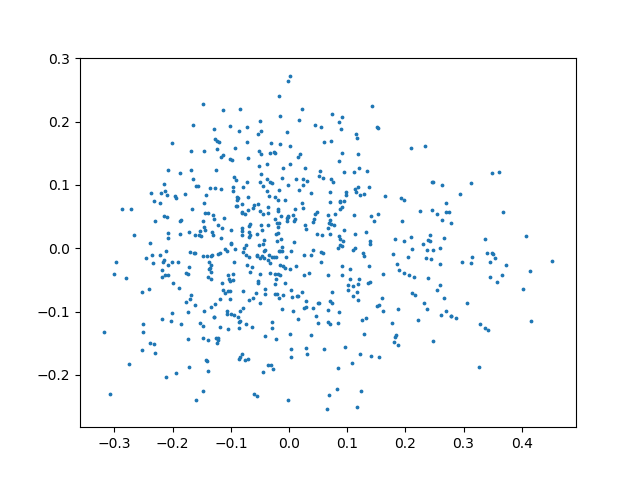

In [14]:
plt.scatter(X[:,0],X[:,1],s=3)
plt.savefig('PCA.png',dpi=300)

## make an interactive map

In [52]:
# package to visualize the structures in the notebook
# https://github.com/arose/nglview#released-version
import nglview

In [53]:
iwdg = nglview.show_asetraj(frames)
# set up the visualization
iwdg.add_unitcell()
iwdg.add_spacefill()
iwdg.remove_ball_and_stick()
iwdg.camera = 'orthographic'
iwdg.parameters = { "clipDist": 0 }
iwdg.center()
iwdg.update_spacefill(radiusType='covalent',
                                   scale=0.6,
                                   color_scheme='element')
iwdg._remote_call('setSize', target='Widget',
                               args=['%dpx' % (600,), '%dpx' % (400,)])
iwdg.player.delay = 200.0

In [54]:
link_ngl_wdgt_to_ax_pos(plt.gca(), X, iwdg)
plt.scatter(X[:,0],X[:,1],s=3)
iwdg

NGLWidget(max_frame=599)